<a href="https://colab.research.google.com/github/kozoB/mone_style_transfer_vgg19/blob/main/mone_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural style transfer - Train
# Final Project - Advanced Topics in Deep Learning

##Import Libraries

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pathlib 
from PIL import Image
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from psutil import virtual_memory

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import IPython.display as display

## Load Dataset

Loading the 'monet' and content datasets from kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# removed kaggle token
! kaggle competitions download gan-getting-started
! kaggle datasets download monet_jpg
! kaggle datasets download photo_jpg
! unzip -n -q gan-getting-started

## Image load and scale functions

In [ ]:
def img_scaler(image, max_dim=320):
  # Casts a tensor to a new type.
  original_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

  # Creates a scale constant for the image
  scale_ratio = max_dim / max(original_shape)

  # Casts a tensor to a new type.
  new_shape = tf.cast(original_shape * scale_ratio, tf.int32)

  # Resizes the image based on the scaling constant generated above (resize to 320x320)
  return tf.image.resize(image, new_shape)

In [ ]:
def load_img(path_to_img):
  # Reads and outputs the entire contents of the input filename.
  img = tf.io.read_file(path_to_img)

  # Detect whether an image is a BMP, GIF, JPEG, or PNG, and 
  # performs the appropriate operation to convert the input 
  # bytes string into a Tensor of type dtype
  img = tf.image.decode_image(img, channels=3)

  # Convert image to dtype, scaling (MinMax Normalization) its values if needed.
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  # Scale the image using the custom function we created
  img = img_scaler(img)

  # Adds a fourth dimension to the Tensor because
  # the model requires a 4-dimensional Tensor
  return img[tf.newaxis, :]

## Load content and style images

In [ ]:
content_image = load_img('/content/photo_jpg/2a4a9d54a7.jpg')
style_image = load_img('/content/monet_jpg/1e4e4e63c5.jpg')

content_image = tf.Variable(content_image, dtype=tf.float32)

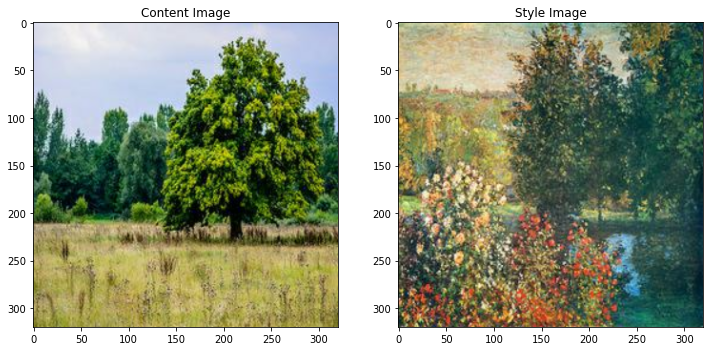

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.title('Style Image')

plt.show()

## VGG19 Architecture

## Base Model

In [ ]:
# Creates a pre-trained VGG model which takes an input and returns a list of intermediate output values 
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""

  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

The Gram matrix is used to represent the style of an image, by calculating the Gram matrix of the feature maps at multiple layers of the VGG19 network, we can capture the style of an image in terms of the correlations between the features. It is achieved by dot-product of the style layers' vectors which gives us the Gram matrix

In [ ]:
def gram_matrix(input_tensor):
  # Tensor contraction over specified indices and outer product.
  # Matrix multiplication
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  # Save the shape of the input tensor
  input_shape = tf.shape(input_tensor)

  # Casts a tensor to a new type.
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  
  # Divide matrix multiplication output to num_locations
  return result/(num_locations)

We define the layer which will be used as 'content layers' and the other layers which will be used as 'style_layers'.
We will select the first convolutional layer of each block for style knowledge. Since intermediate level information is more valuable for transfer learning, we will keep the second convolutional layer of the fifth block for the content layer

In [ ]:
# We will use block5 conv2 layer for content 
content_layers = ['block5_conv2'] 

# We will use conv1 layers from every block for style 
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']


We use model subclassing to pass our data through the custom vgg model and gram matrix.
We create a model named extractor which outputs a dictionary containing values for content and style information

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    # The main 
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False

    # Used as keys in dict creation
    self.style_layers = style_layers
    self.content_layers = content_layers
    # self.num_style_layers = len(style_layers)
    

  def call(self, inputs):
    # Process the image input
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Feed the preprocessed image to the VGG19 model
    outputs = self.vgg(preprocessed_input)
    # Separate style and content outputs
    style_outputs, content_outputs = (outputs[:len(self.style_layers)], 
                                      outputs[len(self.style_layers):])
    # Process style output before dict creation
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]


    # Create two dicts for content and style outputs
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  
extractor = StyleContentModel(style_layers, content_layers)

# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

80134624/80134624 [==============================] - 3s 0us/step


We define the optimzier used for the model and it's hyperparameters as well as compute the style content loss which is the loss of both of them combined - as we try to apply the style onto the image but make it stay similar to the content image

We use the Adam optimizer as it fits our problem and provides good results.
In the base model we try a learning rate of 0.0075 as starting point and was recommended upon research.

The style_weight is defined as 1e8 and the content_weight as 1e-2 to make the ratio between the style_weight and content_weight big so the generated image will apply the style more

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.0075, beta_1=0.99, epsilon=1e-1)

# To optimize this, using a weighted combination of the two losses to get the total loss:
style_weight = 1e8
content_weight = 1e-2

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

We define a custom train_step function where we use GradientTape,which allows us to do automatic differentiation for loss calculation. It records the operations during the forward pass and then can compute the gradient of our loss function for our input image for the backward pass.
The total_variation_weight we chose is 100 as a starting point, so the image will be somewhat detailed but also smooth

In [ ]:
total_variation_weight = 100

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 
                                clip_value_min=0.0, 
                                clip_value_max=1.0))

We create our custom train loop in which we optimize our weights and improve the output image.
The number of epochs and steps_per_epoch is 100 for the base model as a starting point to see how it performs with these values.
The MSE loss is displayed in a graph over iterations

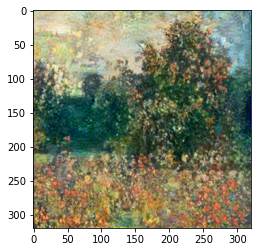

Train step: 10000
MSE style loss: 0.062245466
MSE content loss: 0.03152078


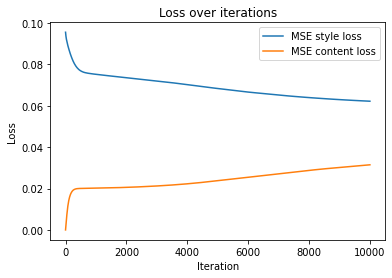

In [ ]:
image = tf.Variable(content_image)
epochs = 100
steps_per_epoch = 100
step = 0
mse_style_loss_values = []
mse_content_loss_values = []
num_iterations = epochs * steps_per_epoch
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        outputs = extractor(content_image)
        loss = style_content_loss(outputs)
        mse = tf.keras.losses.MeanSquaredError()
        mse_style_loss_value = mse(image, style_image).numpy()
        mse_content_loss_value = mse(image, content_image).numpy()
        mse_style_loss_values.append(mse_style_loss_value)
        mse_content_loss_values.append(mse_content_loss_value)
        print(".", end='')
    display.clear_output(wait=True)
    plt.imshow(image[0])
    plt.show()
    print("Train step: {}".format(step))
    print('MSE style loss:', mse_style_loss_value)
    print('MSE content loss:', mse_content_loss_value)

plt.plot(range(num_iterations), mse_style_loss_values, label='MSE style loss')
plt.plot(range(num_iterations), mse_content_loss_values, label='MSE content loss')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


The MSE graph shows the difference between the generated image and the style and content images, we can see that the style loss graph converges lower which means the generated image is applying the style more each iteration, and the content loss graph converges higher which means the generated image is becoming less similar to the content image with each iteration. We strive to balance both losses so the generated image will be similar to the content image and yet contain the style we applied

As we can see the generated image of the base model has the style applied into it but it looks very coarse and the objects in it are not well defined

## Experiment 1 - changing hyper parameters

We increased the content_weight and decreased the style_weight to see if it makes the image closer to the original image, we also decreased the total_variation_weight to make the image more detailed and less smooth.
We experimented with content_weight and decreased the style_weight until the image became both styled and detailed and at the same time less blurry or smeared

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.0075, beta_1=0.99, epsilon=1e-1)

# To optimize this, using a weighted combination of the two losses to get the total loss:
style_weight = 1e-2
content_weight = 1e5

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [ ]:
total_variation_weight = 20

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 
                                clip_value_min=0.0, 
                                clip_value_max=1.0))

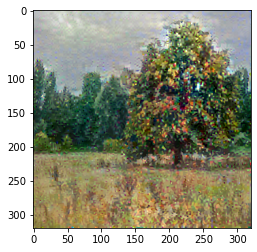

tf.Tensor([320 320   3], shape=(3,), dtype=int32)
Train step: 10000
MSE style loss: 0.068222515
MSE content loss: 0.023095451


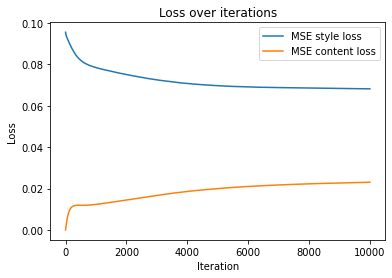

In [ ]:
image = tf.Variable(content_image)
epochs = 100
steps_per_epoch = 100
step = 0
mse_style_loss_values = []
mse_content_loss_values = []

num_iterations = epochs * steps_per_epoch
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        outputs = extractor(content_image)
        loss = style_content_loss(outputs)
        mse = tf.keras.losses.MeanSquaredError()
        mse_style_loss_value = mse(image, style_image).numpy()
        mse_content_loss_value = mse(image, content_image).numpy()
        mse_style_loss_values.append(mse_style_loss_value)
        mse_content_loss_values.append(mse_content_loss_value)
        print(".", end='')
    display.clear_output(wait=True)
    plt.imshow(image[0])
    plt.show()
    print(tf.shape(image[0]))
    print("Train step: {}".format(step))
    print('MSE style loss:', mse_style_loss_value)
    print('MSE content loss:', mse_content_loss_value)

plt.plot(range(num_iterations), mse_style_loss_values, label='MSE style loss')
plt.plot(range(num_iterations), mse_content_loss_values, label='MSE content loss')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see the content loss is considerably lower than the one of the base model, and the style loss is not much different, which means we managed to make the image more similar to the content image but still apply the style 

The generated image in this experiment looks better than the one of the base model as the objects in the image are much better defined and look like the ones in the content image, and also the style looks more natural with the image's objects

## Experiment 2 - Use different conv layers for style loss

This time we will try the last conv layers in each block for the style loss and see how it affects the output image

In [ ]:
# Creates a pre-trained VGG model which takes an input and returns a list of intermediate output values 
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""

  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
# We will use block5 conv2 layer for content 
content_layers = ['block5_conv2'] 

# We will use the last conv layer from every block for style 
style_layers = ['block1_conv2','block2_conv2','block3_conv4', 'block4_conv4','block5_conv4']


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    # The main 
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False

    # Used as keys in dict creation
    self.style_layers = style_layers
    self.content_layers = content_layers
    # self.num_style_layers = len(style_layers)
    

  def call(self, inputs):
    # Process the image input
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Feed the preprocessed image to the VGG19 model
    outputs = self.vgg(preprocessed_input)
    # Separate style and content outputs
    style_outputs, content_outputs = (outputs[:len(self.style_layers)], 
                                      outputs[len(self.style_layers):])
    # Process style output before dict creation
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]


    # Create two dicts for content and style outputs
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  
extractor = StyleContentModel(style_layers, content_layers)

# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.0075, beta_1=0.99, epsilon=1e-1)

# To optimize this, using a weighted combination of the two losses to get the total loss:
style_weight = 1e-2
content_weight = 1e5

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [ ]:
total_variation_weight = 20

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 
                                clip_value_min=0.0, 
                                clip_value_max=1.0))

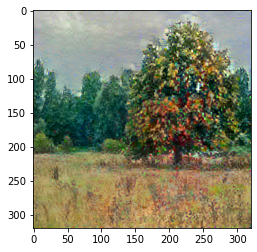

Train step: 10000
MSE style loss: 0.0691559
MSE content loss: 0.022522159


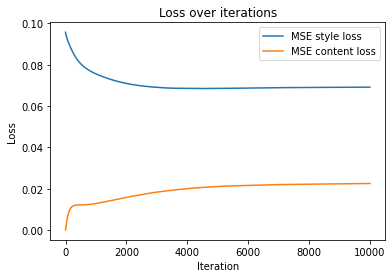

In [ ]:
image = tf.Variable(content_image)
epochs = 100
steps_per_epoch = 100
step = 0
mse_style_loss_values = []
mse_content_loss_values = []
num_iterations = epochs * steps_per_epoch
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        outputs = extractor(content_image)
        loss = style_content_loss(outputs)
        mse = tf.keras.losses.MeanSquaredError()
        mse_style_loss_value = mse(image, style_image).numpy()
        mse_content_loss_value = mse(image, content_image).numpy()
        mse_style_loss_values.append(mse_style_loss_value)
        mse_content_loss_values.append(mse_content_loss_value)
        print(".", end='')
    display.clear_output(wait=True)
    plt.imshow(image[0])
    plt.show()
    print("Train step: {}".format(step))
    print('MSE style loss:', mse_style_loss_value)
    print('MSE content loss:', mse_content_loss_value)

plt.plot(range(num_iterations), mse_style_loss_values, label='MSE style loss')
plt.plot(range(num_iterations), mse_content_loss_values, label='MSE content loss')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


As we can see the content and style losses are similar to the one of experiment 1

The output image is pretty similar to the one of experiment 1, but we can see that there is a little more ephasis on the color (the lower part of the tree and the grass bellow it are a more red than the one of experiment 1)